In [804]:
pip install yfinance xgboost pandas numpy scikit-learn matplotlib


In [2]:
import yfinance as yf  # Fetch stock data
import numpy as np  # Numerical computations
import pandas as pd  # Data handling
import matplotlib.pyplot as plt  # Visualization
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV  # Data splitting and Cross Validation
from sklearn.preprocessing import MinMaxScaler # Scaling
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model evaluation
import xgboost as xgb  # XGBoost model


In [30]:
# Download AAPL stock data for the past 5 years
aapl = yf.download('AAPL', start="2022-01-01", end="2024-01-01")


[*********************100%***********************]  1 of 1 completed


Perform Feature Engineering

In [7]:
def get_features(df):
    
    #Helps model detect long-term trends.
    df['SMA_10'] = df['Close'].rolling(window=10).mean()  # 10-day simple moving average
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
    df['High_Low_Range'] = df['High'] - df['Low']   #Measures daily volatility, which can indicate breakouts or trend reversals.
    df['Open_Close_Change'] = (df['Close'] - df['Open'])/df['Open']  #If the Close > Open, it suggests bullish momentum; otherwise, it's bearish.
    
    # Create lag features 
    df['Close_Lag_1'] = df['Close'].shift(1)    # previous day's closing price
    df['Volume_Lag_1'] = df['Volume'].shift(1)  # Previous day's volume
 

    
    # Drop NaN values created due to rolling calculations
    df.dropna(inplace=True)
    return df

In [31]:
aapl2=get_features(aapl.copy())
aapl2

Price,Close,High,Low,Open,Volume,SMA_10,EMA_50,High_Low_Range,Open_Close_Change,Close_Lag_1,Volume_Lag_1
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2022-01-14,170.093658,170.791440,168.147698,168.393399,80440800,171.878438,176.496643,2.643741,0.010097,169.228821,84505800.0
2022-01-18,166.879898,169.572768,166.496606,168.560482,90956700,170.678439,176.119516,3.076162,-0.009970,170.093658,80440800.0
2022-01-19,163.371277,168.137876,163.086271,167.076447,94815000,169.354604,175.619585,5.051605,-0.022176,166.879898,90956700.0
2022-01-20,161.680862,166.761950,161.356536,164.108386,91420500,168.331503,175.072968,5.405415,-0.014792,163.371277,94815000.0
2022-01-21,159.616959,163.469543,159.508850,161.592386,122848900,167.388992,174.466850,3.960693,-0.012225,161.680862,91420500.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.444595,194.243791,191.818350,194.015153,37122800,194.578773,187.026941,2.425440,-0.008095,193.518127,46482500.0
2023-12-26,191.897858,192.732841,191.679169,192.454513,28919300,194.565849,187.217957,1.053671,-0.002892,192.444595,37122800.0


In [32]:
# Define feature set (X) and target variable (y)
X = aapl2[['SMA_10' ,'EMA_50','High_Low_Range', 'Open_Close_Change','Volume_Lag_1','Close_Lag_1']]  # Input features
y= aapl2['Close'].shift(-1)  # moves the "Close" column one step up, so each row’s target is the next day's closing price. This means for a given day's data, the model will learn to predict the closing price of the next day.



In [33]:
y.dropna(inplace=True)
y.rename(columns={'AAPL':'Target'})

y

Ticker,AAPL
Date,
2022-01-14,166.879898
2022-01-18,163.371277
2022-01-19,161.680862
2022-01-20,159.616959
2022-01-21,158.840576
...,...
2023-12-21,192.444595
2023-12-22,191.897858
2023-12-26,191.997269


In [34]:
X=X.head(-1)
X

Price,SMA_10,EMA_50,High_Low_Range,Open_Close_Change,Volume_Lag_1,Close_Lag_1
Ticker,,,,,,
Date,,,,,,
2022-01-14,171.878438,176.496643,2.643741,0.010097,84505800.0,169.228821
2022-01-18,170.678439,176.119516,3.076162,-0.009970,80440800.0,170.093658
2022-01-19,169.354604,175.619585,5.051605,-0.022176,90956700.0,166.879898
2022-01-20,168.331503,175.072968,5.405415,-0.014792,94815000.0,163.371277
2022-01-21,167.388992,174.466850,3.960693,-0.012225,91420500.0,161.680862
...,...,...,...,...,...,...
2023-12-21,194.788513,186.805812,3.558636,-0.007241,52242800.0,193.667236
2023-12-22,194.578773,187.026941,2.425440,-0.008095,46482500.0,193.518127


In [35]:
# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [36]:
# Scale features between 0 and 1 for better model performance
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500,early_stopping_rounds=20)

# Train the model
model.fit(X_train_scaled, y_train,eval_set=[(X_test_scaled,y_test)])


[0]	validation_0-rmse:18.66936
[1]	validation_0-rmse:13.73572
[2]	validation_0-rmse:10.15929
[3]	validation_0-rmse:8.23337
[4]	validation_0-rmse:6.85276
[5]	validation_0-rmse:5.70565


[6]	validation_0-rmse:5.26353
[7]	validation_0-rmse:4.93330
[8]	validation_0-rmse:4.78542
[9]	validation_0-rmse:4.63320
[10]	validation_0-rmse:4.53339
[11]	validation_0-rmse:4.43134
[12]	validation_0-rmse:4.37901
[13]	validation_0-rmse:4.40930
[14]	validation_0-rmse:4.39185
[15]	validation_0-rmse:4.38171
[16]	validation_0-rmse:4.37740
[17]	validation_0-rmse:4.35896
[18]	validation_0-rmse:4.35440
[19]	validation_0-rmse:4.33515
[20]	validation_0-rmse:4.33282
[21]	validation_0-rmse:4.33088
[22]	validation_0-rmse:4.32969
[23]	validation_0-rmse:4.33449
[24]	validation_0-rmse:4.32280
[25]	validation_0-rmse:4.32544
[26]	validation_0-rmse:4.32888
[27]	validation_0-rmse:4.32353
[28]	validation_0-rmse:4.31195
[29]	validation_0-rmse:4.30732
[30]	validation_0-rmse:4.30603
[31]	validation_0-rmse:4.30446
[32]	validation_0-rmse:4.30633
[33]	validation_0-rmse:4.31115
[34]	validation_0-rmse:4.30051
[35]	validation_0-rmse:4.30015
[36]	validation_0-rmse:4.30477
[37]	validation_0-rmse:4.30235
[38]	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
# Predict on test data
y_pred = model.predict(X_test_scaled)


In [66]:

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 3.25
Root Mean Squared Error (RMSE): 4.04


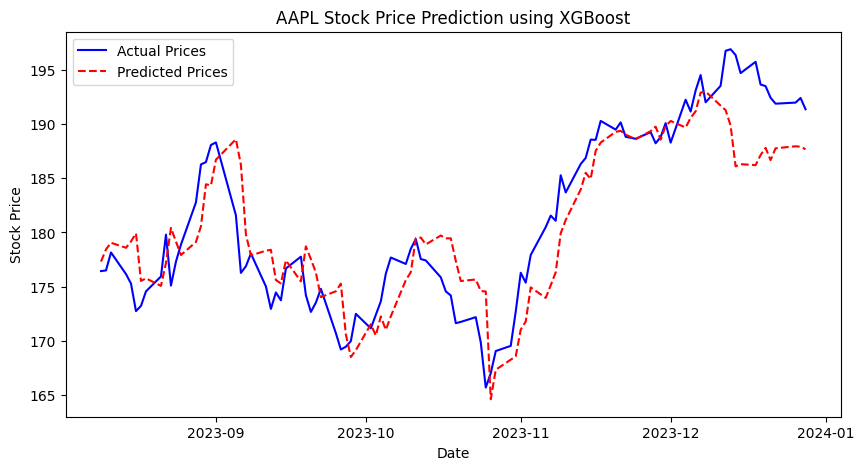

In [59]:
# Plot actual vs. predicted stock prices
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Prediction using XGBoost')
plt.legend()
plt.show()


In [55]:
param_grid1={
    'max_depth':[10,12,15],
    'learning_rate':[0.1,.05,0.01],
    'gamma':[0,1.0,5,10],
    'min_child_weight':[3,5,8,10],
    'subsample':[0.8,.9]
}

In [64]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)

optimum = RandomizedSearchCV(model, param_grid1,random_state=42,scoring="neg_root_mean_squared_error",verbose=3)
search = optimum.fit(X_train_scaled, y_train)
search.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=8, subsample=0.9;, score=-5.890 total time=   2.1s
[CV 2/5] END gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=8, subsample=0.9;, score=-4.112 total time=   2.4s
[CV 3/5] END gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=8, subsample=0.9;, score=-4.693 total time=   4.2s
[CV 4/5] END gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=8, subsample=0.9;, score=-4.124 total time=   3.8s
[CV 5/5] END gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=8, subsample=0.9;, score=-15.514 total time=   2.2s
[CV 1/5] END gamma=5, learning_rate=0.1, max_depth=12, min_child_weight=8, subsample=0.9;, score=-5.659 total time=   0.4s
[CV 2/5] END gamma=5, learning_rate=0.1, max_depth=12, min_child_weight=8, subsample=0.9;, score=-3.991 total time=   0.4s
[CV 3/5] END gamma=5, learning_rate=0.1, max_depth=12, min_child_weight=

{'subsample': 0.8,
 'min_child_weight': 3,
 'max_depth': 15,
 'learning_rate': 0.05,
 'gamma': 10}

In [ ]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)

optimum = GridSearchCV(model, param_grid1,scoring="neg_root_mean_squared_error",verbose=3)
search = optimum.fit(X_train_scaled, y_train)
search.best_params_

In [65]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500,subsample=0.8,min_child_weight=8,max_depth=12,learning_rate=0.05,gamma=5)
# Train the model
model.fit(X_train_scaled, y_train,eval_set=[(X_test_scaled,y_test)])


[0]	validation_0-rmse:24.44998
[1]	validation_0-rmse:23.38591
[2]	validation_0-rmse:22.37875
[3]	validation_0-rmse:21.41746
[4]	validation_0-rmse:20.49343
[5]	validation_0-rmse:19.56751
[6]	validation_0-rmse:18.69960
[7]	validation_0-rmse:17.92957
[8]	validation_0-rmse:17.07188
[9]	validation_0-rmse:16.29121
[10]	validation_0-rmse:15.59778
[11]	validation_0-rmse:14.90935
[12]	validation_0-rmse:14.26736
[13]	validation_0-rmse:13.65036
[14]	validation_0-rmse:13.06066
[15]	validation_0-rmse:12.54250
[16]	validation_0-rmse:12.02275
[17]	validation_0-rmse:11.53198
[18]	validation_0-rmse:11.06073
[19]	validation_0-rmse:10.63460
[20]	validation_0-rmse:10.21214
[21]	validation_0-rmse:9.79947
[22]	validation_0-rmse:9.40079
[23]	validation_0-rmse:9.03914
[24]	validation_0-rmse:8.70090
[25]	validation_0-rmse:8.37928
[26]	validation_0-rmse:8.08774
[27]	validation_0-rmse:7.78630
[28]	validation_0-rmse:7.53148
[29]	validation_0-rmse:7.27978
[30]	validation_0-rmse:7.05206
[31]	validation_0-rmse:6.838

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
# Define the target date
start_date = "2024-01-01"

# Download past stock data (enough history to calculate features)
test = yf.download('AAPL', start=start_date, end=pd.Timestamp(start_date)+pd.Timedelta(days=100))


[*********************100%***********************]  1 of 1 completed


In [5]:
test

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-13,209.679993,216.839996,208.419998,215.949997,61368300
2025-03-14,213.490005,213.949997,209.580002,211.250000,60060200


In [143]:
n=len(test)
n

68

In [144]:
# Fetch the most recent data
latest_data = aapl.tail(50)  # Last 50 days

In [145]:
aug=pd.concat([latest_data,test],axis=0)
aug

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-10-19,174.183365,176.546038,173.915325,174.759131,59302900
2023-10-20,171.622147,174.143659,171.383887,174.034459,64189300
2023-10-23,171.741257,172.743903,168.693587,169.666467,55980100
2023-10-24,172.178070,172.406392,170.202544,171.790908,43816600
2023-10-25,169.855103,171.800833,169.408365,170.629426,57157000
...,...,...,...,...,...
2024-04-03,168.852692,169.877850,167.787728,167.996733,47691700
2024-04-04,168.026611,171.112033,168.026611,169.489689,53704400


In [146]:

aug=get_features(aug)
aug

Price,Close,High,Low,Open,Volume,SMA_10,SMA_50,EMA_50,High_Low_Range,Open_Close_Change,Close_Lag_1,Close_Lag_3,Close_Lag_5,Volume_Lag_1,High_Lag_1,Low_Lag_1,Open_Lag_1
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2023-12-29,191.380951,193.239786,190.585722,192.742770,42628800,193.420723,185.446805,187.370756,2.654063,-0.007065,192.424713,191.897873,193.518112,34049900.0,193.498269,192.017156,192.981369
2024-01-02,184.532074,187.315366,182.792518,186.033057,82488700,192.234840,185.653780,187.259435,4.522848,-0.008068,191.380951,191.997269,192.444595,42628800.0,193.239786,190.585722,192.742770
2024-01-03,183.150375,184.770652,182.335262,183.120556,58414500,191.077788,185.884344,187.098296,2.435390,0.000163,184.532074,192.424713,191.897873,82488700.0,187.315366,182.792518,186.033057
2024-01-04,180.824341,181.997291,179.800489,181.062899,71983600,189.583755,186.066006,186.852258,2.196802,-0.001318,183.150375,191.380951,191.997269,58414500.0,184.770652,182.335262,183.120556
2024-01-05,180.098694,181.669266,179.094727,180.903872,62303300,188.226900,186.224418,186.587413,2.574539,-0.004451,180.824341,184.532074,192.424713,71983600.0,181.997291,179.800489,181.062899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03,168.852692,169.877850,167.787728,167.996733,47691700,170.812450,179.059609,176.757534,2.090122,0.005095,168.046494,170.674103,168.912430,49329500.0,168.544144,167.439360,168.285371
2024-04-04,168.026611,171.112033,168.026611,169.489689,53704400,169.832080,178.539838,176.415145,3.085422,-0.008632,168.852692,169.230927,172.495499,47691700.0,169.877850,167.787728,167.996733


In [148]:
# Define feature set (X) and target variable (y)
X_unseen = np.array(aug[['SMA_10' ,'EMA_50','High_Low_Range', 'Open_Close_Change','Volume_Lag_1','Close_Lag_1']].tail(n) ) # Input features
X_unseen


array([[ 1.92234840e+02,  1.87259435e+02,  4.52284800e+00,
        -8.06836525e-03,  4.26288000e+07,  1.91380951e+02],
       [ 1.91077788e+02,  1.87098296e+02,  2.43539026e+00,
         1.62842140e-04,  8.24887000e+07,  1.84532074e+02],
       [ 1.89583755e+02,  1.86852258e+02,  2.19680194e+00,
        -1.31754182e-03,  5.84145000e+07,  1.83150375e+02],
       [ 1.88226900e+02,  1.86587413e+02,  2.57453900e+00,
        -4.45086429e-03,  7.19836000e+07,  1.80824341e+02],
       [ 1.87320345e+02,  1.86503693e+02,  4.07553693e+00,
         1.90565176e-02,  6.23033000e+07,  1.80098694e+02],
       [ 1.86479391e+02,  1.86406884e+02,  2.40555537e+00,
         6.63332554e-03,  5.91445000e+07,  1.84452560e+02],
       [ 1.85797485e+02,  1.86354803e+02,  2.46519500e+00,
         9.98099418e-03,  4.28418000e+07,  1.84035065e+02],
       [ 1.85045998e+02,  1.86281375e+02,  3.40953758e+00,
        -5.09272533e-03,  4.67929000e+07,  1.85078812e+02],
       [ 1.84284567e+02,  1.86223690e+02,  1.540

In [149]:
# Reuse the same scaler fitted during training
X_unseen_scaled = scaler.transform(X_unseen)

In [ ]:
# Predict the next day's closing price
actual_prices = aug['Close'].shift(-1).tail(n).dropna()
predicted_price = model.predict(X_unseen_scaled)
predicted_price = predicted_price[:len(actual_prices)]  # Align lengths



Predicted Closing Price: $[187.33621 183.28526 182.36029 179.61562 180.50406 184.40582 185.16989
 184.28241 183.55502 185.17586 182.10611 182.15805 186.75807 188.36847
 190.40746 189.58643 189.80252 189.96176 188.4102  187.29672 184.77469
 183.45958 183.82472 182.51639 186.53955 185.47385 184.99869 186.85135
 185.25131 183.99959 182.81685 183.25539 181.26472 180.42421 181.40244
 182.00533 182.01382 179.28745 180.75386 179.55759 179.85477 180.19562
 176.20738 172.94319 168.8647  172.12105 171.32446 172.46684 175.29405
 168.74648 171.81184 171.4931  168.39084 172.48341 173.96822 169.97278
 172.48991 172.49326 168.21211 170.03938 170.32393 170.03293 167.82936
 168.26237 165.58885 168.02296 167.11436 167.27925]
Actual Closing Price: $Ticker            AAPL
Date                  
2024-01-02  183.150375
2024-01-03  180.824341
2024-01-04  180.098694
2024-01-05  184.452560
2024-01-08  184.035065
...                ...
2024-04-02  168.852692
2024-04-03  168.026611
2024-04-04  168.783035
2024-04

In [ ]:
# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)

mae = mean_absolute_error(actual_prices, predicted_price)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_price))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 2.43
Root Mean Squared Error (RMSE): 3.14


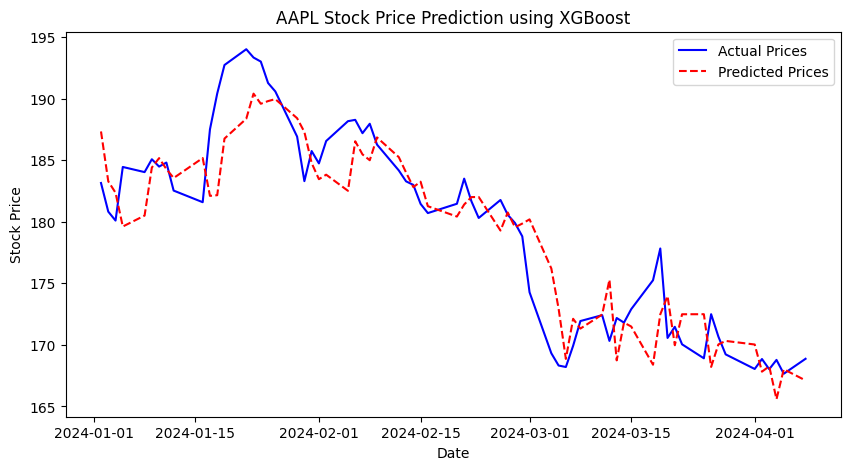

In [184]:
# Plot actual vs. predicted stock prices
plt.figure(figsize=(10, 5))
plt.plot(actual_prices.index, actual_prices, label='Actual Prices', color='blue')
plt.plot(actual_prices.index, predicted_price, label='Predicted Prices', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Prediction using XGBoost')
plt.legend()
plt.show()
